In [1]:
!pip install pennylane scikit-learn pandas matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane import numpy as npq

In [3]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

X = df.drop(columns=['target']).values
y = df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

X_norm = np.array([x / np.linalg.norm(x) for x in X_pca])
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [9]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(x, weights):
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=True)
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

def quantum_model(x, weights):
    return circuit(x, weights)

In [10]:
def compute_loss(weights, X, y):
    preds = npq.array([quantum_model(x, weights) for x in X])
    preds = (preds + 1) / 2
    return np.mean((preds - y) ** 2)

def predict(X, weights):
    preds = npq.array([quantum_model(x, weights) for x in X])
    preds = (preds + 1) / 2
    return (preds > 0.5).astype(int)

In [11]:
from pennylane.optimize import NesterovMomentumOptimizer

# Initialize weights
weights = 0.01 * npq.random.randn(2, 3)

# Optimizer
opt = NesterovMomentumOptimizer(stepsize=0.5)

# Training settings
epochs = 20
losses = []

# Fixed loss function using npq.sum instead of np.mean
def compute_loss(weights, X, y):
    preds = npq.array([quantum_model(x, weights) for x in X])
    preds = (preds + 1) / 2  # map from [-1, 1] to [0, 1]
    errors = (preds - y) ** 2
    return npq.sum(errors) / len(errors)

# Training loop
for epoch in range(epochs):
    weights, loss = opt.step_and_cost(lambda w: compute_loss(w, X_train, y_train), weights)
    losses.append(loss)
    print(f"Epoch {epoch+1:02d} | Loss: {loss:.4f}")


Epoch 01 | Loss: 0.3089
Epoch 02 | Loss: 0.3085
Epoch 03 | Loss: 0.3078
Epoch 04 | Loss: 0.3068
Epoch 05 | Loss: 0.3056
Epoch 06 | Loss: 0.3039
Epoch 07 | Loss: 0.3018
Epoch 08 | Loss: 0.2993
Epoch 09 | Loss: 0.2964
Epoch 10 | Loss: 0.2931
Epoch 11 | Loss: 0.2897
Epoch 12 | Loss: 0.2865
Epoch 13 | Loss: 0.2839
Epoch 14 | Loss: 0.2821
Epoch 15 | Loss: 0.2812
Epoch 16 | Loss: 0.2813
Epoch 17 | Loss: 0.2819
Epoch 18 | Loss: 0.2827
Epoch 19 | Loss: 0.2835
Epoch 20 | Loss: 0.2840


In [12]:
y_pred = predict(X_test, weights)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")


Test Accuracy: 0.5263


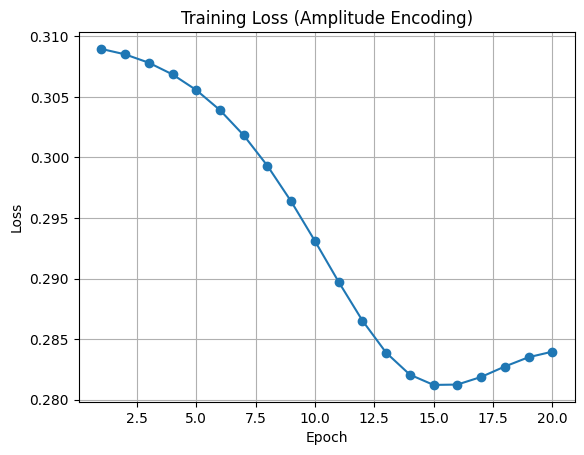

In [13]:
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (Amplitude Encoding)")
plt.grid(True)
plt.show()